In [1]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [3]:
files = os.listdir(path)

In [4]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [5]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [6]:
p = kb.psf(1.5)
object_count = 1
x_range = (5,3650)
y_range = (5, 3650)
xv_range = (800,2750)
yv_range = (100,1800)
flux_range = (8999, 9000)

Search Parameters

In [7]:
min_observations = 3
angle_range = tuple( math.atan(yv/xv) for xv,yv in zip(xv_range, yv_range))
velocity_range = tuple( math.sqrt(xv**2+yv**2) for xv,yv in zip(xv_range, yv_range))
angle_steps = 200
velocity_steps = 180

In [8]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4552089907465616
2480.4899110791043


Generate Random trajectories within bounds

In [9]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    traj.x_v = rd.uniform(*xv_range)
    traj.y_v = rd.uniform(*yv_range)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [10]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key[0]

lh: 0.000000 flux: 8999.846680 x: 264 y: 2251 x_v: 1507.224609 y_v: 606.178650 obs_count: 0

Test that clustering is not able to collapse together too many unique trajectories

In [11]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

2

Use the generated trajectories to add objects into the images

In [12]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [13]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

2

In [14]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [15]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [16]:
stack.apply_mask_flags(flags, flag_exceptions)

In [17]:
stack.apply_master_mask(master_flags, 2)

In [18]:
images = [i.science() for i in stack.get_images()]

In [19]:
img = images[1] 

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [20]:
percent_masked = img[np.where(img==-9999.99)].size/img.size
percent_masked

0.15934744897959183

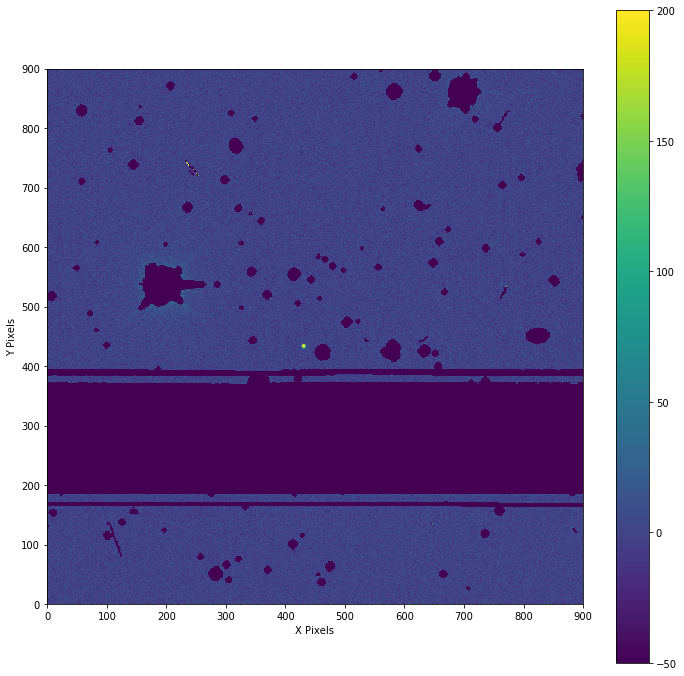

In [21]:
fig = plt.figure(figsize=(12,12))
plt.imshow(img[2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [22]:
search = kb.stack_search(stack, p)

In [23]:
search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [24]:
psi_imgs = search.get_psi()

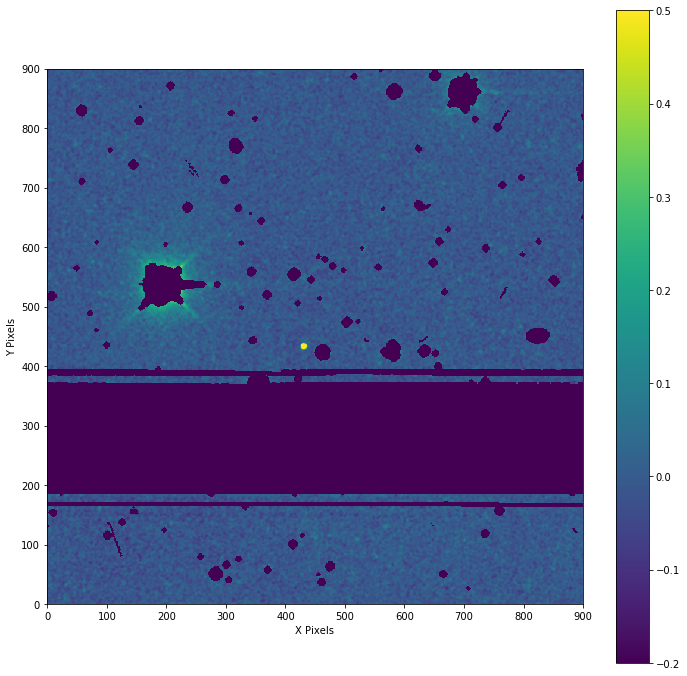

In [25]:
fig = plt.figure(figsize=(12,12))
plt.imshow(psi_imgs[1][2700:3600,2900:3800], origin='lower',  vmin=-0.2, vmax=0.5)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [26]:
#search.filter_min_obs(min_observations)

In [27]:
results = search.get_results(0, 15000)

In [28]:
#results = [t for t in results if t.obs_count>=min_observations]

In [29]:
len(results)

15000

Cluster results

In [30]:
results_clustered = [ results[i] 
    for i in cluster_trajectories(results, dbscan_args=dict(eps=0.004, min_samples=1))[1] ]

In [31]:
#search.save_results("filtered.txt", 0.03)

In [32]:
len(results_clustered)

2182

In [33]:
#results_clustered

In [34]:
#results_key

Calculate an upper bound for number of detections

In [35]:
maximum_expected_detections(stack.img_count(), min_observations, percent_masked, len(results_key))

1.756169694227031

In [36]:
results_matched, results_unmatched = match_trajectories(results_clustered, results_key, 0.015, 2)

In [37]:
print('matched: '+ str(len(results_matched)))
print('unmatched: ' + str(len(results_unmatched)))

matched: 2
unmatched: 0


In [38]:
results_matched

[lh: 399.659943 flux: 8390.628906 x: 265 y: 2251 x_v: 1501.455688 y_v: 606.368469 obs_count: 4,
 lh: 270.433838 flux: 9907.183594 x: 3124 y: 3044 x_v: 2423.889893 y_v: 1043.670166 obs_count: 3]

In [1]:
results_unmatched

NameError: name 'results_unmatched' is not defined

Choose the set of results to analyze

In [40]:
results_to_plot = results_unmatched
#                 results - raw results from the search
#                 results_clustered - raw results clustered
#                 results_matched - results that matched with the key
#                 reults_unmatched - results from the key that were not found
#                 results_key - the list of known artificial objects

In [41]:
stamps = [create_postage_stamp(images, t, stack.get_times(), [21,21])[0] for t in results_to_plot]

Starting at 0


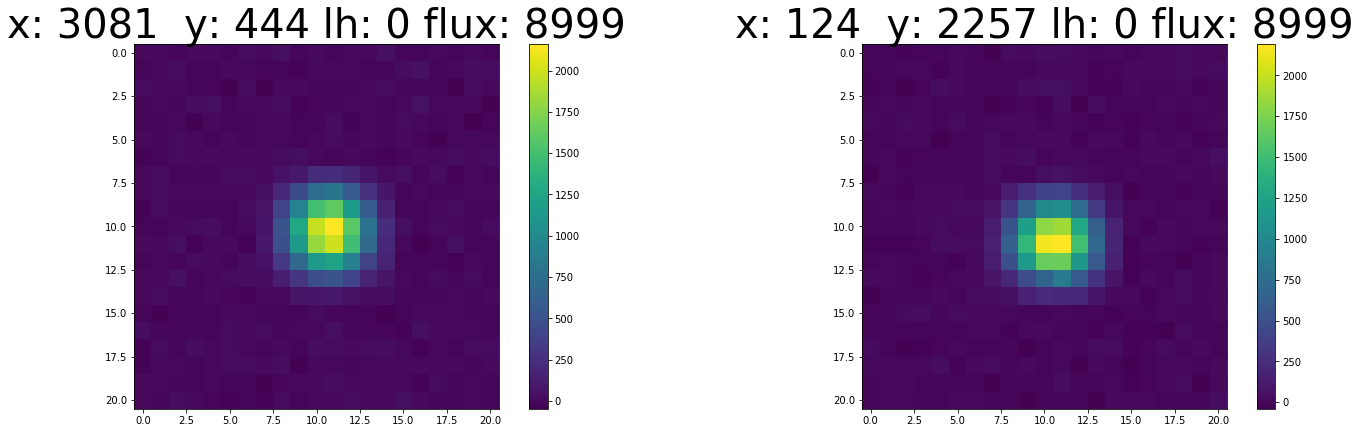

In [257]:
fig = plt.figure(figsize=(50, 200))
set_on = 1
plot_count = min(100,len(stamps))
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(25,4,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r,
               interpolation=None)
    rplt=results_to_plot[i]
    plt.title('x: {0}  y: {1} lh: {2:.3g} flux: {3:.4g}'.format(rplt.x, rplt.y,rplt.lh, rplt.flux) , fontsize=40)
    plt.colorbar()

In [193]:
def plot_histogram(results_to_plt, bins, x_rng, y_rng, name, title, color):
# the histogram of the data
    n, bins, patches = plt.hist(np.array(results_to_plt), bins, normed=0, facecolor=color, alpha=0.75)

    # add a 'best fit' line
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel(name)
    plt.ylabel('Detections')
    plt.title(title)
    #plt.axis([*x_rng, *y_rng])
    plt.grid(True)

    plt.show()

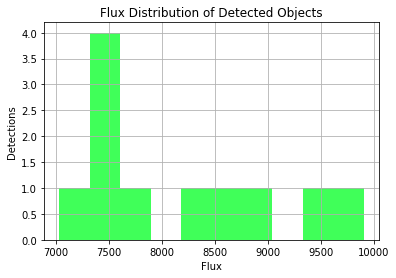

In [194]:
plot_histogram([t.flux for t in results_to_plot], 10, 
flux_range, (0,40), 'Flux', 'Flux Distribution of Detected Objects', '#00ff22')

In [185]:
#plot detection ratio for flux, lh, velocities, angle

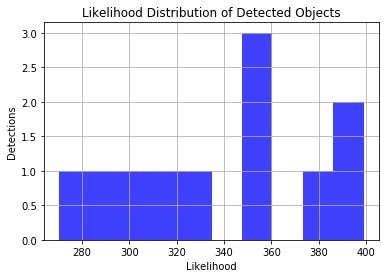

In [188]:
plot_histogram([t.lh for t in results_to_plot], 10,
(0, 350), (0,50), 'Likelihood', 'Likelihood Distribution of Detected Objects', 'blue')

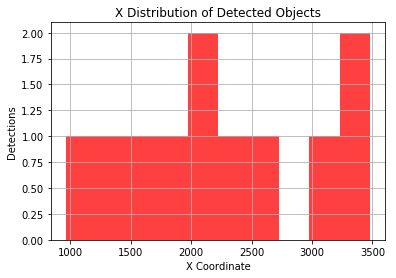

In [190]:
plot_histogram([t.x for t in results_to_plot], 10,
(0, 4096), (0,20), 'X Coordinate', 'X Distribution of Detected Objects', 'red')

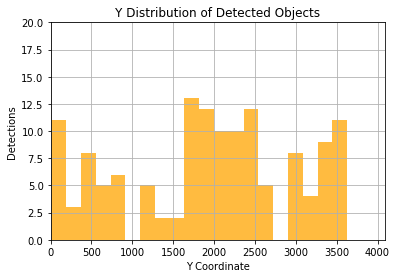

In [98]:
plot_histogram([t.y for t in results_to_plot], 20, 
(0, 4096), (0,20), 'Y Coordinate', 'Y Distribution of Detected Objects', 'orange')

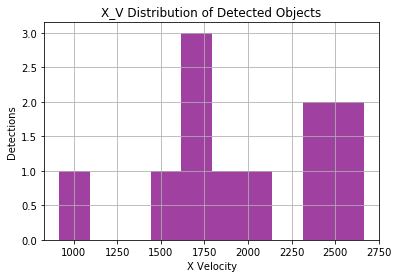

In [196]:
plot_histogram([t.x_v for t in results_to_plot], 10, 
(0, 4096), (0,20), 'X Velocity', 'X_V Distribution of Detected Objects', 'purple')

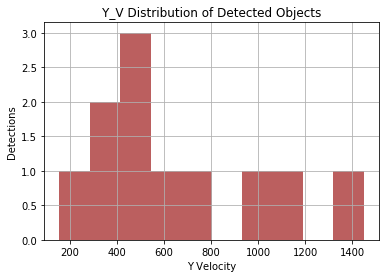

In [198]:
plot_histogram([t.y_v for t in results_to_plot], 10, 
(0, 4096), (0,20), 'Y Velocity', 'Y_V Distribution of Detected Objects', 'brown')